<a href="https://colab.research.google.com/github/HongJieYang/Age-Gender-Emotion-Detector/blob/main/Age_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# VGGFace based on architecture
from IPython.display import clear_output
!pip install keras_vggface
clear_output()

In [ ]:
# Required for VGGFace
!pip install keras_applications
clear_output()

In [ ]:
# Set up directory
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
os.chdir('/content')

Mounted at /content/drive


In [ ]:
# Create local copy 
!cp "/content/drive/MyDrive/test/faces.zip" .
!unzip -q "/content/faces.zip"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image

## **Load and Organize the Images Based on Age**

In [ ]:
#load data (Downloaded from https://talhassner.github.io/home/projects/Adience/Adience-data.html)
os.chdir('/content/drive/MyDrive/data')
fold_0 = pd.read_csv("fold_0_data.txt",sep = "\t" )
fold_1 = pd.read_csv("fold_1_data.txt",sep = "\t")
fold_2 = pd.read_csv("fold_2_data.txt",sep = "\t")
fold_3 = pd.read_csv("fold_3_data.txt",sep = "\t")
fold_4 = pd.read_csv("fold_4_data.txt",sep = "\t")

In [ ]:
# Combined data_set
total_data = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
print(total_data.shape)
total_data.info()
total_data.head()

(19370, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [ ]:
# Replace singular ages with their corresponding ranges
map_dict = {
    "13": "(8, 12)",
    "2" : "(0, 2)",
    "22": "(15, 20)",
    "23": "(25, 32)",
    "29": "(25, 32)",
    "3" : "(0, 2)",
    "32": "(25, 32)",
    "34": "(25, 32)",
    "35": "(25, 32)",
    "36": "(38, 43)",
    "42": "(38, 43)",
    "45": "(38, 43)",
    "46": "(48, 53)",
    "55": "(48, 53)",
    "56": "(48, 53)",
    "57": "(60, 100)",
    "58": "(60, 100)",
    
    "(8, 23)" : "(8, 12)",
    "(27, 32)": "(25, 32)",
    "(38, 42)": "(38, 43)",
    "(38, 48)": "(38, 43)",
}

def map_func(x):
    if x in map_dict:
        return map_dict[x]
    else:
        return x

df = total_data.replace('None', np.nan).dropna() # Remove empty values from dataset
df["age"] = df["age"].map(map_func)

df["age"].value_counts()
df.shape[0]
total_data.shape[0]

19370

## **Prepare Pictures for Data Loader Based on Age**

In [ ]:
import shutil
folder_path = "/content/faces/faces"

In [ ]:
# Generate list of picture paths
file_list = []
formats = ["jpg", "png"]

for subdir in os.listdir(folder_path):
    subpath = os.path.join(folder_path, subdir)

    if os.path.isdir(subpath):

        for f in os.listdir(subpath):
      
            filepath = os.path.join(subpath, f)
            part = f.split(".")
      
            if os.path.isfile(filepath) and part[-1] in formats: # Is jpg or png
                file_list.append((filepath, f))

print(len(file_list))
print(file_list[0])

19370
('/content/faces/faces/101532586@N07/coarse_tilt_aligned_face.1262.9714006981_a39baceef9_o.jpg', 'coarse_tilt_aligned_face.1262.9714006981_a39baceef9_o.jpg')


In [ ]:
# Sort images into different folders based on age
im_len = len(file_list)
for i, (filepath, filename) in enumerate(file_list):

    # get the identifiers
    parts = filename.split(".")
    user_id = filepath.split("/")[-2]
    file_id = parts[-2] + "." + parts[-1]
    face_id = int(parts[-3])

    try:

      # find class label
      class_ = df[
        (df["user_id"] == user_id) & 
        (df["original_image"] == file_id) & 
        (df["face_id"] == face_id)
      ]["age"].values[0]

      new_path = os.path.join(folder_path, class_)
      
      if not os.path.exists(new_path):
          os.makedirs(new_path)

      # move file
      new_path = os.path.join(new_path, filename)
      shutil.move(filepath, new_path)
    
    except:
      pass

    # progress
    prog = (20 * (i + 1)) // im_len
    print("\r[" + "="*prog + "_"*(20-prog) + "]", end="")\

[====================]

In [ ]:
# delete unwanted files or empty folders
for subdir in os.listdir(folder_path):
    subpath = os.path.join(folder_path, subdir)

    if os.path.isdir(subpath):
        if subdir[0] != "(":
            shutil.rmtree(subpath)
    elif os.path.isfile(subpath):
        os.remove(subdir)

In [ ]:
# Set up new folders to match current convention
os.mkdir(folder_path + "/(00, 02)")
os.mkdir(folder_path + "/(04, 06)")
os.mkdir(folder_path + "/(08, 12)")

In [ ]:
source = "/content/faces/faces/(0, 2)/"
destination = "/content/faces/faces/(00, 02)/"

allfiles = os.listdir(source)

for f in allfiles:
  shutil.move(source + f, destination + f)

In [ ]:
source = "/content/faces/faces/(4, 6)/"
destination = "/content/faces/faces/(04, 06)/"

allfiles = os.listdir(source)

for f in allfiles:
  shutil.move(source + f, destination + f)

In [ ]:
source = "/content/faces/faces/(8, 12)/"
destination = "/content/faces/faces/(08, 12)/"

allfiles = os.listdir(source)

for f in allfiles:
  shutil.move(source + f, destination + f)

In [ ]:
# Delete old folders
os.rmdir("/content/faces/faces/(0, 2)/")
os.rmdir("/content/faces/faces/(4, 6)/")
os.rmdir("/content/faces/faces/(8, 12)/")

In [ ]:
import keras
from keras.applications.vgg16 import VGG16

## **Split Up Folders into Training, Validation, and Testing Datasets**

In [ ]:
!pip install split-folders
clear_output()

In [ ]:
import splitfolders
splitfolders.ratio("/content/faces/faces", output="/content/output", seed=1337, ratio=(.7, .15, .15), group_prefix=None)

Copying files: 18551 files [00:11, 1580.41 files/s]


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = "/content/output/train"
valid_path = "/content/output/val"
test_path  = "/content/output/test"

## **Train the Model Based on Modified VGGFace Architecture**

In [ ]:
# Need to replace 'from keras.engine.topology import get_source_inputs with' 
# 'from tensorflow.keras.utils import get_source_inputs' in models.py
from keras_vggface.vggface import VGGFace

vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

58925056/58909280 [==============================] - 5s 0us/step


In [ ]:
# Using feature extraction transfer learning, freeze base layer's parameters
for layer in vgg_features.layers:
    layer.trainable = False

print(vgg_features.summary())

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [ ]:
# Number of output classes
folders = glob('/content/output/train/*')

# Add dense and dropout layers to perform the predictions
test_model = Model(inputs=vgg_features.input, outputs=vgg_features.layers[-2].output)
x = Flatten()(test_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=test_model.input, outputs=prediction)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [ ]:
# Set up cost and optimizer 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.00001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 12983 images belonging to 8 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 2788 images belonging to 8 classes.


In [ ]:
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2780 images belonging to 8 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
p = model.fit(
  training_set,
  validation_data=val_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set),
)

Epoch 1/15
406/406 [==============================] - 251s 589ms/step - loss: 1.6164 - accuracy: 0.4197 - val_loss: 1.2292 - val_accuracy: 0.5781
Epoch 2/15
406/406 [==============================] - 223s 550ms/step - loss: 1.1429 - accuracy: 0.5898 - val_loss: 0.9468 - val_accuracy: 0.6712
Epoch 3/15
406/406 [==============================] - 223s 549ms/step - loss: 0.9634 - accuracy: 0.6398 - val_loss: 0.8369 - val_accuracy: 0.7043
Epoch 4/15
406/406 [==============================] - 223s 549ms/step - loss: 0.8725 - accuracy: 0.6736 - val_loss: 0.7800 - val_accuracy: 0.7205
Epoch 5/15
406/406 [==============================] - 222s 548ms/step - loss: 0.8179 - accuracy: 0.6911 - val_loss: 0.7489 - val_accuracy: 0.7320
Epoch 6/15
406/406 [==============================] - 223s 549ms/step - loss: 0.7716 - accuracy: 0.7094 - val_loss: 0.7199 - val_accuracy: 0.7378
Epoch 7/15
406/406 [==============================] - 223s 549ms/step - loss: 0.7388 - accuracy: 0.7201 - val_loss: 0.6944 -

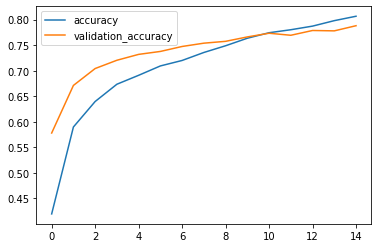

In [ ]:
plt.plot(p.history['accuracy'], label='accuracy')
plt.plot(p.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

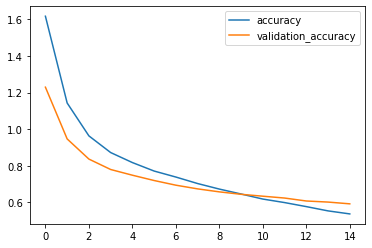

In [ ]:
plt.plot(p.history['loss'], label='accuracy')
plt.plot(p.history['val_loss'], label='validation_accuracy')
plt.legend()
plt.show()

## **Model Performance Results**

In [ ]:
model.save('/content/model/')

INFO:tensorflow:Assets written to: /content/model/assets


In [ ]:
from tensorflow import keras
test_model = keras.models.load_model('/content/model/')

In [ ]:
# Get list of pictures from test set
filenames = test_set.filenames
num_samples = len(filenames)

In [ ]:
# Get predictions for the test set
y_pred = model.predict(test_set, steps=num_samples)
pred = np.argmax(y_pred, axis=1)

In [ ]:
# Convert one hot encoding to integer and calculate total accuracy + one off accuracy
labels = []
count = 0
neighbour = 0
for i in range(len(pred)):

  labels.append(np.argmax(test_set[i][1][0]))

  if test_set[i][1][0][pred[i]] == 1:
    count = count + 1
  elif test_set[i][1][0][max(0, pred[i] - 1)] == 1:
    neighbour = neighbour + 1
  elif test_set[i][1][0][min(7, pred[i] + 1)] == 1:
    neighbour = neighbour + 1

labels = np.asarray(labels)

In [ ]:
# Accuracy and one off accuracy
print(count)
print(count / len(pred))
print(neighbour)
print((count + neighbour) / len(pred))

2196
0.787661406025825
481
0.9601865136298422


In [ ]:
# Confusion matrix
confusion = tf.math.confusion_matrix(labels=labels, predictions=pred, num_classes=8).numpy()
norm_confusion = np.around(confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis], decimals=2)

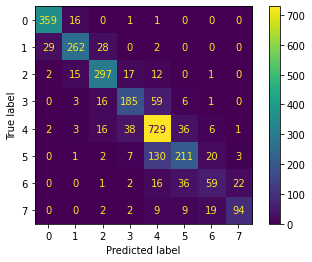

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(labels, pred)

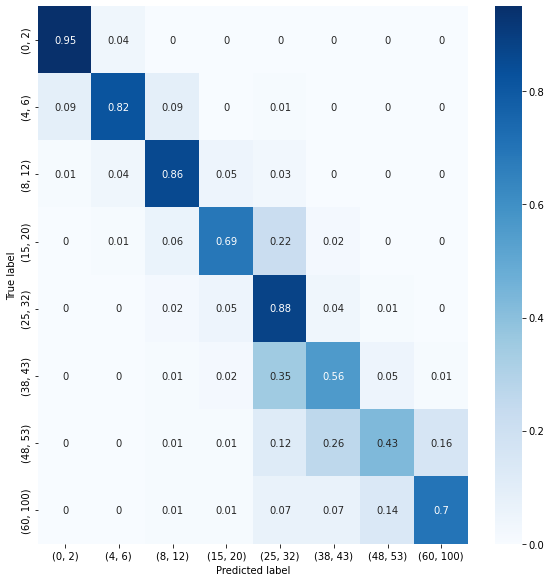

In [ ]:
# Normalized confusion matrix
classes = ["(0, 2)", "(4, 6)", "(8, 12)", "(15, 20)", "(25, 32)", "(38, 43)", "(48, 53)", "(60, 100)"]
con_mat_df = pd.DataFrame(norm_confusion,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

(48, 53)
(48, 53)


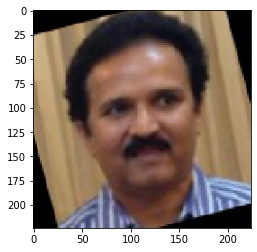

In [ ]:
# Test the model and showcase some examples
age_dict = {
    0: "(0, 2)",
    1: "(4, 6)",
    2: "(8, 12)",
    3: "(15, 20)",
    4: "(25, 32)",
    5: "(38, 43)",
    6: "(48, 53)",
    7: "(60, 100)"
}

nums = 2566

img = test_set[nums][0]
img = np.squeeze(img)
print(age_dict[pred[nums]])
print(age_dict[np.argmax(test_set[nums][1][0])])
plt.imshow(img[:, :, :])

In [ ]:
# Export the model as a zip file
shutil.make_archive("model_age_", "zip", "/content/model")

'/content/drive/MyDrive/data/model_age_.zip'